# Danish vowels sound classification with convolutional neural network

By Dimitra Christoforidi and Thea H. Nørgaard, MA Linguistics, Aarhus University

In [2]:
# Install Tensorflow and Matplotlib
!pip install tensorflow tensorflow-gpu tensorflow-io matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 5.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 5.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.9/25.9 MB 24.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.7/126.7 KB 1.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 40.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 37.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.3 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 27.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 KB 390.4 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [53]:
# Import required modules
import subprocess
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import zipfile

In [55]:
# Unzip files
zip_file = os.path.join('vowels','16bit_data.zip')
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall('vowels')
        print("Extracted all")
except:
    print("Invalid file")

Extracted all


### Create tensorflow dataset

In [56]:
# Define file paths for the two folders containing front or back vowels, respectively
FRONT =  os.path.join('vowels', '16bit_data_3', 'front') 
BACK =  os.path.join('vowels', '16bit_data_3', 'back') 

# Load the wav-files in each directory into a tensorflow dataset
front = tf.data.Dataset.list_files(FRONT+'/*.wav')
back = tf.data.Dataset.list_files(BACK+'/*.wav')

# Add labels to the front and back vowels
front_lab = tf.data.Dataset.zip((front, tf.data.Dataset.from_tensor_slices(tf.ones(len(front)))))
back_lab = tf.data.Dataset.zip((back, tf.data.Dataset.from_tensor_slices(tf.zeros(len(back)))))
# Concatinate the data
data = front_lab.concatenate(back_lab)
len(data)

68

### Build dataloading function 

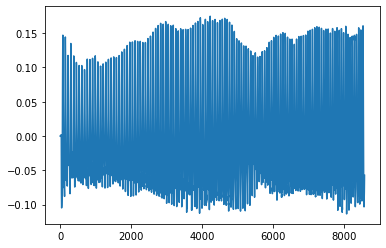

In [57]:
def load_wav_16k_mono(filename):
    '''Input: .wav-file. Output: .wav-file monochannel, 16000 Hz '''
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels = 1)
    # Remove trailing axis
    wav = tf.squeeze(wav, axis =-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000Hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

# To demonstrate what the above function does
## Load a single /i/
single_i = os.path.join('vowels', '16bit_data_3', 'front', 'f01_01.wav')
# Create and plot the new modified .wav-file
wave = load_wav_16k_mono(single_i)
plt.plot(wave)
plt.show()

### Determine average length of the vowel recordings

In [58]:
# Lengths of the whole dataset
lengths = []
for file in os.listdir(FRONT):
    tensor_wave = load_wav_16k_mono(os.path.join('vowels','16bit_data_3','front',file))
    lengths.append(len(tensor_wave))    
for file in os.listdir(BACK):
    tensor_wave = load_wav_16k_mono(os.path.join('vowels','16bit_data_3','back',file))
    lengths.append(len(tensor_wave))
lengths.sort()
print(lengths)

FailedPreconditionError: vowels/16bit_data_3/front/.ipynb_checkpoints; Is a directory [Op:ReadFile]

In [ ]:
# Lenghts of only the files below 10,000 frames
short_lengths = []
for length in lengths:
    if length > 10000:
        pass   
    else:
        short_lengths.append(length)
short_lengths.sort()
print(short_lengths)                        

In [59]:
# Mean length of short_lengths
tf.math.reduce_mean(short_lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=5260>

### Build preprocessing function to convert to spectrogram

#### Build preprocessing function

In [60]:
def preprocess(file_path, label):
    # Load the file with load_wav_16k_mono function
    wav = load_wav_16k_mono(file_path)
    # Take only the first 5000 steps
    wav = wav[:5000]
    # If the wav-file is shorter than 5000 steps, pad it with zeros at the start of the file
    zero_padding = tf.zeros([5000]-tf.shape(wav),dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    # Create spectrogram with the short form fourier transform (.stft)
    s = tf.signal.stft(wav, frame_length = 320, frame_step = 32)
    # Convert it into absolute values
    s = tf.abs(s)
    # Add one more dimension (with .expand_dims) as this is the required format for the CNN 
    s = tf.expand_dims(s, axis=2)
    return s, label

#### Test out the function and vizualize the spectrogram 

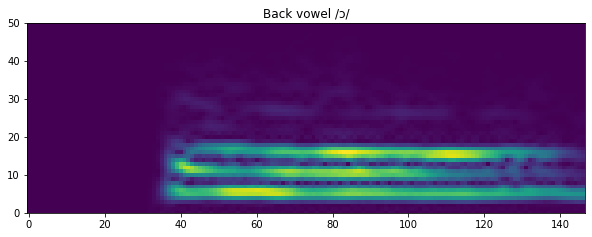

In [61]:
# A random spectrogram from the backvowels /å/
filepath, label = back_lab.shuffle(buffer_size = 10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(10,7))
plt.ylim(0,50)
plt.imshow(tf.transpose(spectrogram)[0])
plt.title('Back vowel /ɔ/')
plt.savefig('backvowel.png')
plt.show()

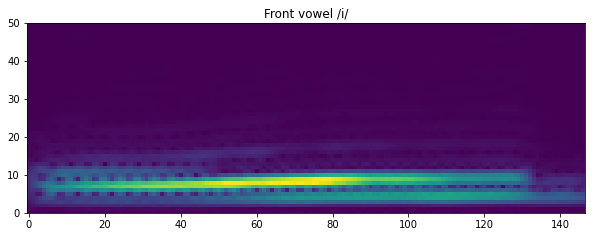

In [62]:
# A random spectrogram from the front vowels /i/
filepath2, label2 = front_lab.shuffle(buffer_size = 10000).as_numpy_iterator().next()
spectrogram2, label2 = preprocess(filepath2, label2)
plt.figure(figsize=(10,7))
plt.ylim(0,50)
plt.imshow(tf.transpose(spectrogram2)[0])
plt.title('Front vowel /i/')
plt.savefig('frontvowel.png')
plt.show()

### Create training and testing partitions

Here, the data, which is currently just individual string with a path to .wav file in, will be converted in to spectrograms for the CNN  to work with
#### Create a Tensorflow data pipeline 


In [63]:
print(f'Before preproccesing, the length of the dataset was:',len(data))

Before preproccesing, the length of the dataset was: 68


In [64]:
# Preprocess the data
data = data.map(preprocess)
# Cache the data
data = data.cache()
# Shuffle the traning samples to mix up their order
data = data.shuffle(buffer_size=1000)
# Batch it up to train at 16 samples at a time
data = data.batch(16)
# Prefetch 8 examples to eliminate potential cpu bottleneck
data = data.prefetch(8)

#### Split into traning and test partitions

In [65]:
# Here, we check the length of our data
print(f'After preprocessing and batching the data, is is now:', len(data))
# 70 % of this length
print(f'70 % of this length is:', len(data)*0.7)
# 70% of this length rounded
print(f'Rounded it is:', round(len(data)*0.7), '''
This will be the length of the training sample''')

After preprocessing and batching the data, is is now: 5
70 % of this length is: 3.5
Rounded it is: 4 
This will be the length of the training sample


In [66]:
# Training data with 4 of the 16-batch samples
train = data.take(4)
# Test data, here we skip the initial 4 and take the remaining 1
test = data.skip(4).take(1)

#### Test the shape of one batch

In [67]:
samples, labels = train.as_numpy_iterator().next()


In [68]:
# This is the shape of the samples
# The numbers of this should be used as input shape when specifying the model
samples.shape

(16, 147, 257, 1)

### Build deep learning model

#### Load Tensorflow dependencies

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Activation

#### Build sequential model, compile and view summary

In [70]:
# Define sequential model
model = Sequential()
# Add convolutional layers:
model.add(Conv2D(16,(3,3), activation='relu', input_shape=(147, 257, 1)))
model.add(Conv2D(16,(3,3), activation='relu'))
## Flatten the layer into a single dimension:
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [71]:
# Compile the model
model.compile('Adam', loss = 'BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [72]:
# Let's have a look at the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 145, 255, 16)      160       
                                                                 
 conv2d_3 (Conv2D)           (None, 143, 253, 16)      2320      
                                                                 
 flatten_1 (Flatten)         (None, 578864)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               74094720  
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 74,097,329
Trainable params: 74,097,329
Non-trainable params: 0
_________________________________________________________________


#### Fit model, view loss and KPI plots

Let's train the model

In [73]:
# Train the model for 4 epochs 
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
4/4 [==============================] - 2s 310ms/step - loss: 0.5958 - recall_1: 0.8750 - precision_1: 0.7568 - val_loss: 7.7588e-05 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 2/4
4/4 [==============================] - 1s 219ms/step - loss: 0.7184 - recall_1: 0.9333 - precision_1: 0.9655 - val_loss: 0.1260 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 3/4
4/4 [==============================] - 1s 215ms/step - loss: 0.2693 - recall_1: 0.8710 - precision_1: 1.0000 - val_loss: 0.5641 - val_recall_1: 0.5000 - val_precision_1: 1.0000
Epoch 4/4
4/4 [==============================] - 1s 214ms/step - loss: 0.1079 - recall_1: 0.9688 - precision_1: 0.9688 - val_loss: 3.2031e-04 - val_recall_1: 1.0000 - val_precision_1: 1.0000


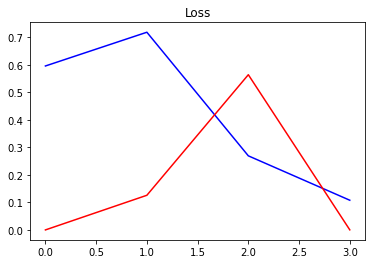

In [74]:
plt.title('Loss')
plt.plot(hist.history['loss'],'b')
plt.plot(hist.history['val_loss'], 'r')
plt.savefig('loss.png')
plt.show()

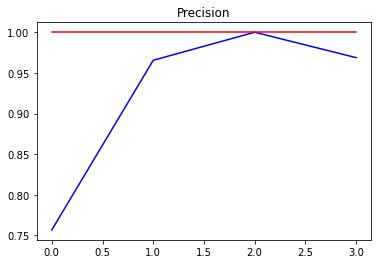

In [76]:
plt.title('Precision')
plt.plot(hist.history['precision_1'], 'b')
plt.plot(hist.history['val_precision_1'], 'r')
plt.savefig('precision.png')
plt.show()

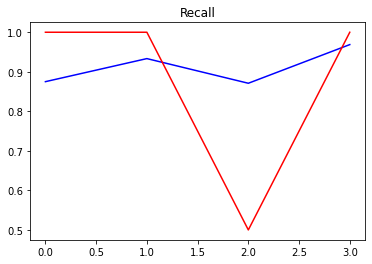

In [78]:
plt.title('Recall')
plt.plot(hist.history['recall_1'], 'b')
plt.plot(hist.history['val_recall_1'], 'r')
plt.savefig('recall.png')
plt.show()

In [79]:
hist

In [80]:
hist.history

{'loss': [0.5958353281021118,
  0.7184434533119202,
  0.2693021893501282,
  0.1079498827457428],
 'recall_1': [0.875, 0.9333333373069763, 0.8709677457809448, 0.96875],
 'precision_1': [0.7567567825317383, 0.9655172228813171, 1.0, 0.96875],
 'val_loss': [7.758813444525003e-05,
  0.12598130106925964,
  0.564095139503479,
  0.00032031271257437766],
 'val_recall_1': [1.0, 1.0, 0.5, 1.0],
 'val_precision_1': [1.0, 1.0, 1.0, 1.0]}

In [72]:
hist.history['loss']

[10.746267318725586,
 0.5962384939193726,
 0.06639770418405533,
 0.6186553239822388]

### Make a prediction on a single clip

#### Get one batch and make a prediction

In [126]:
X_test, Y_test = test.as_numpy_iterator().next()
X_test, Y_test

(array([[[[0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00],
          ...,
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00]],
 
         [[0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00],
          ...,
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00]],
 
         [[0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00],
          ...,
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00]],
 
         ...,
 
         [[1.22467913e-02],
          [7.28621939e-03],
          [3.44361253e-02],
          ...,
          [3.93819346e-06],
          [2.66012285e-06],
          [4.84287739e-08]],
 
         [[1.17843039e-02],
          [5.24284830e-03],
          [3.88497561e-02],
          ...,
          [4.17914680e-06],
          [2.65063295e-06],
          [1.65030360e-06]],
 
         [[7.09457323e-03],
          [2.67760064e-02]

In [127]:
Y_test.shape

(4,)

In [128]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 36ms/step


In [129]:
yhat

array([[1.0000000e+00],
       [6.3395067e-24],
       [5.7070202e-04],
       [1.0000000e+00]], dtype=float32)

In [130]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [131]:
yhat

[1, 0, 0, 1]

In [132]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [133]:
tf.math.reduce_sum(Y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

In [134]:
Y_test.astype(int)

array([1, 0, 0, 1])

### Save the model as a JSON file

From https://www.youtube.com/watch?v=mdkQ3s-u2cU&t=333s

In [73]:
# Save the model as a json file
model_json = model.to_json()
with open('model.json', 'w') as file:
    file.write(model_json)

In [74]:
# Store the training weigths in another file
model.save_weights('weights.h5')

In [75]:
# Let's try to load the model and the weights back into this notebook and make predictions with it
from tensorflow.keras.models import model_from_json

with open('model.json', 'r') as file:
    model_json = file.read()
    
loaded_model = model_from_json(model_json)

In [76]:
loaded_model.load_weights('weights.h5')

In [77]:
# Now, we can use the newly loaded model to predict X_test as we did above
yhat_from_jsonfile = loaded_model.predict(X_test)

1/1 [==============================] - 0s 68ms/step


In [78]:
yhat_from_jsonfile

array([[0.69380987],
       [0.69380987],
       [0.69380987],
       [0.69380987]], dtype=float32)

In [79]:
score = model.evaluate(x = X_test, y = Y_test)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])
print('Test prediction: ', score[2])

1/1 [==============================] - 0s 36ms/step - loss: 0.7746 - recall_1: 1.0000 - precision_1: 0.5000
Test loss:  0.7745532393455505
Test accuracy:  1.0
Test prediction:  0.5
